# Modeling Pit Stop Strategy in Formula 1 

## Data Pre-processing

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

races = pd.read_csv('./data/races.csv')
lap_times = pd.read_csv('./data/lap_times.csv')
pit_stops = pd.read_csv('./data/pit_stops.csv')
results = pd.read_csv('./data/results.csv')

### Initial filtering/sampling
This includes removing all strategies with the following conditions:
- Race took place before 2014
- Car didn't complete the race
- Finished outside the top 10
- Finished worse than their starting grid position
- Had a lap exceeding 2:12 minutes
- Pit stops longer than 32 seconds
- Pit stops before lap 5
- Pit stops after lap 65

All of these conditions indicate bad or atypical circumstances.

(Click cells hidden to view code)

In [5]:
# remove unneeded columns from races
races = races.iloc[:, 0:6]
races.drop(['round', 'date'], axis=1, inplace=True)

# remove unneeded columns from results
results = results.loc[:, ['raceId', 'driverId', 'grid', 'positionOrder', 'statusId']]

# remove unneeded columns from lap_times
lap_times.drop('time', axis=1, inplace=True)

# remove unneeded columns from pit_stops
pit_stops.drop(['time', 'duration'], axis=1, inplace=True)

# remove races older than 2014 with Boolean indexing
races = races[races['year'] >= 2014]

# inner join results with races to create a dataframe of strategies
strategies = results.set_index('raceId').join(races.set_index('raceId'), rsuffix='_race', how='inner')

# keep only strategies that complete a race
strategies = strategies[strategies['statusId'] == 1]

# keep only strategies that place top 10
strategies = strategies[strategies['positionOrder'] <= 10]

In [6]:
# mark strategies that finished worse than they started
max_pos_lost = 0 # acceptable number of positions lost from starting position
strategies = strategies.reset_index()
strategies['bad'] = 0 # add a new colum to mark bad strategies

for row in zip(strategies['positionOrder'], strategies['grid'], range(len(strategies))):
    if row[0] - row[1] > max_pos_lost:
        strategies.at[row[2], 'bad'] = 1

In [7]:
# remove bad rows
strategies = strategies[strategies['bad'] == 0]

# inner join lap_times with an empty frame created from strategies to create the dataframe 
# this will filter out raceId/driverId rows that aren't present in strategies
filter_frame = strategies.loc[:, ['raceId', 'driverId', 'circuitId']].set_index(['raceId', 'driverId'])
df = lap_times.set_index(['raceId', 'driverId']).join(filter_frame, how='inner')
df = df.reset_index() 

We will do this operation a lot to remove entire strategies from the data frame easily, so I will make a function for it.

In [9]:
# remove bad rows and update df to reflect new strategies 
def update_df():
    global strategies
    global df
    global filter_frame
    
    strategies = strategies[strategies['bad'] == 0]
    strategies = strategies.reset_index()
    filter_frame = strategies.loc[:, ['raceId', 'driverId']].set_index(['raceId', 'driverId'])
    df = df.set_index(['raceId', 'driverId']).join(filter_frame, how='inner')
    df = df.reset_index() 

In [10]:
# mark strategies with a lap time above max_laptime
max_laptime = 132000 # longest acceptable lap time
strategies = strategies.set_index(['raceId', 'driverId'])

for row in zip(df['milliseconds'], df['raceId'], df['driverId']):
    if row[0] > max_laptime:
        strategies.at[(row[1], row[2]), 'bad'] = 1
        
update_df()

The lap_times and pit_stops of all cars will be used to calculate useful metrics later, so I will join this data together and save it before further filtering.

In [12]:
# inner join lap_times to races
lap_times = lap_times.set_index('raceId').join(races.set_index('raceId'), how='inner')
lap_times = lap_times.reset_index()
# left join pit_stops to lap_times
pit_stops = pit_stops.set_index(['raceId','driverId','lap'])
lap_times = lap_times.set_index(['raceId','driverId','lap'])
lap_times = lap_times.join(pit_stops, on=['raceId','driverId','lap'], rsuffix='_pitstop', how='left')
lap_times = lap_times.reset_index()

In [13]:
# remove pit stops not in strategies
pit_stops = pit_stops.join(filter_frame, how='inner')
pit_stops = pit_stops.reset_index() 

# mark strategies with bad pit stops
max_pitstop = 32000
pit_early = 5
pit_late = 65
strategies = strategies.set_index(['raceId', 'driverId'])

for row in zip(pit_stops['milliseconds'], pit_stops['lap'], pit_stops['raceId'], pit_stops['driverId']):
    if row[0] > 0:
        if (row[0] > max_pitstop) or (row[1] <= pit_early) or (row[1] >= pit_late):
            strategies.at[(row[2], row[3]), 'bad'] = 1

update_df()

Here we join the pit stop data and create the target column for our model, pitNext.

In [15]:
# left join pit_stops to df
pit_stops = pit_stops.set_index(['raceId','driverId','lap'])
df = df.join(pit_stops, on=['raceId','driverId','lap'], rsuffix='Pitstop', how='left')

# create boolean for pit stop next lap
pit_stops = pit_stops.reset_index()
pit_next_lap = pit_stops.loc[:, ['lap']] - 1 # to add the bool the lap before 
pit_next_lap['raceId'] = pit_stops['raceId']
pit_next_lap['driverId'] = pit_stops['driverId']
pit_next_lap['pitNext'] = 1

# left join pit_next_lap to df
pit_next_lap = pit_next_lap.set_index(['raceId','driverId','lap'])
df = df.join(pit_next_lap, on=['raceId','driverId','lap'], how='left')
df['pitNext'] = df['pitNext'].fillna(0)

### Data processing

Here I add additional columns with information processed from the data. This will provide valuable additional insight to the model.
I will add columns for:
- Laps since last pit stop
- Race progress value between 0 and 1
- Time split from the previous lap
- Total time since race start
- Time gap to the car ahead
- Is DRS available
- Time gap to the car behind
- Did the car ahead pit stop
- Did the car behind pit stop

(Click cells hidden to view code)

In [ ]:
# calculate laps since last pit

count = 0

def last_pit(lap, pitstop):
    global count
    
    if (lap == 1) or (not np.isnan(pitstop)):
        count = 0
        return count
    
    count += 1
    return count
    
df['lapsSincePit'] = [
    last_pit(row[0], row[1])
    for row in zip(df['lap'], df['stop'])
]

In [ ]:
# create race progress column

# reverse df for easy iteration backwards
reverse_df = df.iloc[::-1].reset_index().iloc[:,1::]

race_length = 0

def progress(lap):
    global race_length
    
    if lap > race_length:
        race_length = lap
        
    prog = lap / race_length
    
    if lap == 1:
        race_length = 0
    
    return prog

reverse_df['raceProgress'] = [
    progress(row[0])
    for row in zip(reverse_df['lap'])
]

# unreverse df
df = reverse_df.iloc[::-1].reset_index().iloc[:,1::]

In [ ]:
# time split from previous lap 

prev = 0

def split_calculate(lap, laptime):
    global prev
    
    if lap == 1:
        prev = laptime
        return 0
        
    split = laptime - prev
    prev = laptime
    
    return split
    

df['split'] = [
    split_calculate(row[0], row[1])
    for row in zip(df['lap'], df['milliseconds'])
]

In [ ]:
# create column with total time since race start in df

prev = 0;

def total_calc(lap, laptime):
    global prev
    
    if lap == 1:
        prev = laptime
        return laptime
    
    prev += laptime
    
    return prev

df['totalTime'] = [
    total_calc(row[0], row[1])
    for row in zip(df['lap'], df['milliseconds'])
]

In [ ]:
# create column with total time since race start in lap_times 
# this is needed to calculate time gaps for any car

lap_times['totalTime'] = [
    total_calc(row[0], row[1])
    for row in zip(lap_times['lap'], lap_times['milliseconds'])
]

In [ ]:
# create a column with the time gap to the car ahead

max_gap = 40000

def gap_ahead(position, raceId, lap, totalTime):
    if position > 1:
        car_ahead = position - 1
        
        car_ahead_time = lap_times.loc[
            (lap_times['raceId'] == raceId) & 
            (lap_times['lap'] == lap) & 
            (lap_times['position'] == car_ahead), 
            'totalTime'
        ].iloc[0]
        
        gap = totalTime - car_ahead_time
        return gap
    return max_gap

print('Calculating gapAhead...')
df['gapAhead'] = [
    gap_ahead(row[0], row[1], row[2], row[3])
    for row in zip(df['position'], df['raceId'], df['lap'], df['totalTime'])
]
print('Done')

In [ ]:
# mark strategies with a large or negative gap, indicating bad data
strategies = strategies.set_index(['raceId', 'driverId'])

for row in zip(df['gapAhead'], df['raceId'], df['driverId']):
    if not np.isnan(row[0]):
        if row[0] > max_gap or row[0] < 0:
            strategies.at[(row[1], row[2]), 'bad'] = 1
         
update_df()

In [ ]:
# DRS available boolean?

df['DRS'] = [
    (1 if row[0] < 1000 else 0)
    for row in zip(df['gapAhead'])    
]

In [ ]:
# calculate gap to the car behind 

max_bgap = 90000

def gap_behind(position, raceId, lap, totalTime):
    try:
        car_behind = position + 1
        
        car_behind_time = lap_times.loc[
            (lap_times['raceId'] == raceId) & 
            (lap_times['lap'] == lap) & 
            (lap_times['position'] == car_behind), 
            'totalTime'
        ].iloc[0]
        
        gap = car_behind_time - totalTime
        return gap
    except:    
        return max_bgap

print('Calculating gapBehind...')
df['gapBehind'] = [
    gap_behind(row[0], row[1], row[2], row[3])
    for row in zip(df['position'], df['raceId'], df['lap'], df['totalTime'])
]
print('Done')

In [ ]:
# mark strategies with a negative gap, indicating bad data
strategies = strategies.set_index(['raceId', 'driverId'])

for row in zip(df['gapBehind'], df['raceId'], df['driverId']):
    if not np.isnan(row[0]):
        if row[0] > max_bgap or row[0] < 0:
            strategies.at[(row[1], row[2]), 'bad'] = 1
            
update_df()

In [ ]:
# did the car ahead pit boolean?

def pit_ahead(position, raceId, lap):
    if position > 1:
        car_ahead = position - 1
        
        car_ahead_stop = lap_times.loc[
            (lap_times['raceId'] == raceId) & 
            (lap_times['lap'] == lap) & 
            (lap_times['position'] == car_ahead), 
            'stop'
        ].iloc[0]
        
        if not np.isnan(car_ahead_stop):
            return 1
        return 0
    
    return 0

print('Calculating pitAhead...')
df['pitAhead'] = [
    pit_ahead(row[0], row[1], row[2])
    for row in zip(df['position'], df['raceId'], df['lap'])
]
print('Done')

In [ ]:
# did the car behind pit bool?

def pit_behind(position, raceId, lap):
    try:
        car_behind = position + 1
        
        car_behind_stop = lap_times.loc[
            (lap_times['raceId'] == raceId) & 
            (lap_times['lap'] == lap) & 
            (lap_times['position'] == car_behind), 
            'stop'
        ].iloc[0]
        
        if not np.isnan(car_behind_stop):
            return 1
        return 0
    except:
        return 0

print('Calculating pitBehind...')
df['pitBehind'] = [
    pit_behind(row[0], row[1], row[2])
    for row in zip(df['position'], df['raceId'], df['lap'])
]
print('Done')

### Data Analysis

In [ ]:
plt.hist(df['milliseconds'].values, bins=80)
plt.show()

This histogram shows the distribution of lap times. From this we can see an outlier below 60000ms which comes from the 2020 Sakhir Grand Prix. This race will be removed to better train the model.

In [ ]:
strategies = strategies[strategies['raceId'] != 1046]
update_df()

In [ ]:
plt.figure(figsize=(10,5))
plt.scatter(df['lap'], df['millisecondsPitstop'])
plt.show()

Export the finalized dataframe for easy use without reprocessing the raw data.

In [ ]:
df.to_csv('processed_data.csv', index=False)

## LSTM Recurrent Neural Network

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, precision_score, recall_score
import random

df = pd.read_csv('processed_data.csv')

# seperate data from 3/102 races for testing
df_test = df[df['raceId'].isin([1131, 1130, 1123])]
df_train = df[~df['raceId'].isin([1131, 1130, 1123])]

In [2]:
X_test = df_test.iloc[:, 2:5].join(df.iloc[:, 9:12]).join(df.iloc[:, 13::])
y_test = df_test.iloc[:, 8]
X_train = df_train.iloc[:, 2:5].join(df.iloc[:, 9:12]).join(df.iloc[:, 13::])
y_train = df_train.iloc[:, 8]

X_test

,lap,position,milliseconds,lapsSincePit,raceProgress,split,gapAhead,DRS,gapBehind,pitAhead,pitBehind
30309,1,11,94503,0,0.017241,0,815,1,260,0,0
30310,2,11,84284,1,0.034483,-10219,1044,0,320,0,0
30311,3,11,82978,2,0.051724,-1306,952,1,614,0,0
30312,4,10,83742,3,0.068966,764,1258,0,577,0,0
30313,5,10,83294,4,0.086207,-448,996,1,843,0,0
...,...,...,...,...,...,...,...,...,...,...,...
32635,67,2,69532,16,0.943662,-17500,3061,0,1253,0,0
32636,68,2,69241,17,0.957746,-291,2657,0,2393,0,0
32637,69,2,69159,18,0.971831,-82,2069,0,2976,0,0
32638,70,2,69989,19,0.985915,830,2431,0,2688,0,0


In [3]:
X_train = torch.tensor(X_train.values).float()
X_test = torch.tensor(X_test.values).float()
y_train = torch.tensor(y_train.values).float().unsqueeze(1)
y_test = torch.tensor(y_test.values).float().unsqueeze(1)

X_test_original = X_test # save to create the segments using laps
X_train_original = X_train

In [4]:
# minmax the data
min_val = X_train.min(axis=0)[0]  # Column-wise min
max_val = X_train.max(axis=0)[0]  # Column-wise max
X_train = (X_train - min_val) / (max_val - min_val)  # Scale training data to [0, 1]
X_test = (X_test - min_val) / (max_val - min_val)    # Scale test data using training min and max

In [5]:
def LSTM_data_segments(X_orig, X, y, WS):
    X_segments = []
    y_values = []
    i = 0
    while (i < len(X)):
        if X_orig[i][0] == 1: # if lap = 1, jump to lap window size
            i += WS - 1
            continue
        X_segments.append(X[i-WS+1:i+1]) # append the window
        y_values.append(y[i]) # append the pit stop decision
        i += 1

    # convert to tensors
    X_segments = torch.stack(X_segments)  # stack X_segments list into a single tensor
    y_values = torch.stack(y_values)
    return X_segments, y_values

WS = 3 # window size (number of laps to evaluate at a time)

X_test, y_test = LSTM_data_segments(X_test_original, X_test, y_test, WS)
X_train, y_train = LSTM_data_segments(X_train_original, X_train, y_train, WS)

In [6]:
# custom batches based on complete strategies
def LSTM_data_batches(X, y):
    X_batches = []
    y_batches = []

    j = 0
    for i in range(len(X)):

        if X[i][2][4] > 0.999: # race progress == 1 (end of race)
            X_batches.append(X[j:i+1])
            y_batches.append(y[j:i+1])
            j = i + 1

    return X_batches, y_batches
    
X_test_batches, y_test_batches = LSTM_data_batches(X_test, y_test)
X_train_batches, y_train_batches = LSTM_data_batches(X_train, y_train)

In [7]:
class LSTMHybrid(nn.Module):
    def __init__(self, input_size=11, hidden_size=128, num_layers=2, output_size=1):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers    
        
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)

        self.fc_layers = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size)  # Final output layer
        )

    def forward(self, x):
        hidden_states = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        cell_states = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        
        out, _ = self.lstm(x, (hidden_states, cell_states)) # pass through LSTM layers
        out = out[:, -1, :]  # Get the output of the last time step
        
        # pass through fully connected layers
        out = self.fc_layers(out)
        
        return out

In [8]:
model = LSTMHybrid(11, 128, 2, 1)

pit_weight = ((len(y_train) - y_train.sum()) / y_train.sum()) # calculated weight
print(pit_weight)

criterion = nn.BCEWithLogitsLoss(pos_weight = pit_weight) # binary cross entropy loss function
optimizer = optim.Adam(model.parameters(), lr=0.0005)

tensor(35.4897)


In [9]:
num_epochs = 25
losses = []
data_loader = list(zip(X_train_batches, y_train_batches))

for epoch in range(num_epochs):
    epoch_loss = 0

#    random.shuffle(data_loader)
    for X_batch, y_batch in data_loader:
        # forward pass
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)

        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
    
    epoch_loss /= len(X_train_batches)
    losses.append(epoch_loss)
    if (epoch + 1) % 5 == 0:
        print(f'Epoch [{epoch + 1}], Loss: {epoch_loss}')

Epoch [5], Loss: 1.0006236757195408
Epoch [10], Loss: 0.937305924970118
Epoch [15], Loss: 0.896791040169003
Epoch [20], Loss: 0.8712144398458621
Epoch [25], Loss: 0.8526457803676667


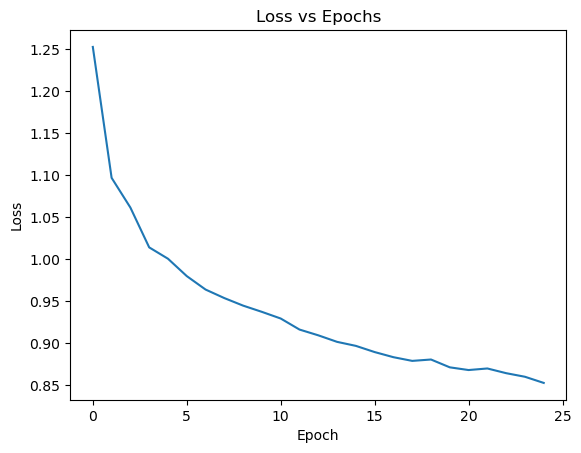

In [14]:
#plt.figure(figsize=(10,5))
plt.plot(range(0, len(losses)), losses[0::])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epochs')
plt.show()

In [16]:
model.eval()
total_loss = 0.0
predictions = []
true_labels = []

with torch.no_grad():  # disable gradient computation
    
    for X_batch, y_batch in zip(X_test_batches, y_test_batches):
        # Forward pass
        y_pred = model(X_batch)
        # Calculate loss
        loss = criterion(y_pred, y_batch)
        total_loss += loss.item()  # Accumulate total loss

        predictions.append(y_pred)
        true_labels.append(y_batch)

average_loss = total_loss / len(X_test_batches)

predictions = torch.cat(predictions)  # Combine all predictions into a single tensor
true_labels = torch.cat(true_labels)  # Combine all true labels into a single tensor

# Print average loss
print(f'Average Loss on Test Set: {average_loss}')

Average Loss on Test Set: 1.5311418282985687


In [17]:
# reasemble the predictions from the segments (insert the missing laps as 0s)
result = []
j = 0
for i in range(len(X_test_original)):
    if X_test_original[i][0] >= WS:
        result.append(torch.sigmoid(predictions[j]))
        j += 1
    else:
        result.append(0)

print(len(X_test_original), len(result))

1623 1623


In [20]:
test = df_test.copy()
test['predictedNext'] = result
race1 = test[test['raceId'] == 1130] # 1131 most recent
print(race1['driverId'].unique())
driver1_1 = race1[race1['driverId'] == 1] #1 847
driver2_1 = race1[race1['driverId'] == 815] #807 #832 is good 815

[  1 815 830 832 844 847 857]


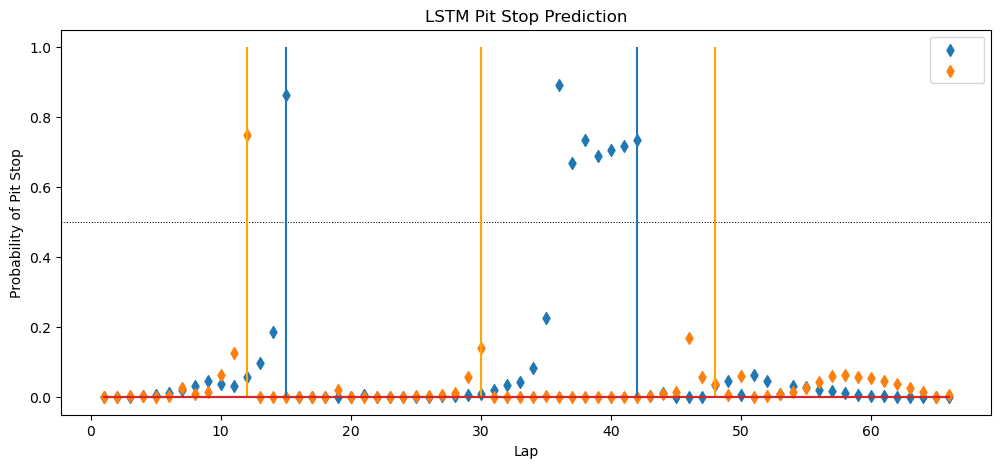

In [21]:
plt.figure(figsize=(12,5))
plt.axhline(y=0.5, color='black', linestyle=':', linewidth=0.75)
plt.scatter(driver1_1['lap'], driver1_1['predictedNext'], marker='d', label=' ')
plt.stem(driver1_1['lap'], driver1_1['pitNext'], markerfmt='none')
plt.scatter(driver2_1['lap'], driver2_1['predictedNext'], marker='d', label=' ')
plt.stem(driver2_1['lap'], driver2_1['pitNext'], markerfmt='none', linefmt='orange')
plt.xlabel('Lap')
plt.ylabel('Probability of Pit Stop')
plt.title('LSTM Pit Stop Prediction')
plt.legend()
plt.show()

### Evaluation

Using the F1 score which measures both precision and recall

Recall (Sensitivity or True Positive Rate): The ratio of true positives to all actual positives (both true positives and false negatives) is more important

In [24]:
f1 = f1_score((test['pitNext'] > 0), (test['predictedNext'] >= 0.5))
recall = recall_score((test['pitNext'] > 0), (test['predictedNext'] >= 0.5))
precision = precision_score((test['pitNext'] > 0), (test['predictedNext'] >= 0.5))

print(f1, recall, precision)

0.3369565217391304 0.6078431372549019 0.23308270676691728


### Saving the model

In [110]:
# saving the model

save_state = {
    'model':model.state_dict(), 
    'optimizer':optimizer.state_dict(), 
    'min_val': min_val,
    'max_val': max_val
    }
torch.save(save_state, 'LSTM_hybrid_trained_2.0_V8.pth')

## User Interface

In [376]:
state = torch.load('LSTM_hybrid_trained_2.0_V3.pth')

model.load_state_dict(state['model'])
optimizer.load_state_dict(state['optimizer'])
min_val = state['min_val']
max_val = state['max_val']

model.eval()

LSTMHybrid(
  (lstm): LSTM(11, 128, num_layers=2, batch_first=True)
  (fc_layers): Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=128, bias=True)
    (7): ReLU()
    (8): Linear(in_features=128, out_features=1, bias=True)
  )
)

In [ ]:
import ipywidgets as widgets
from IPython.display import display

# create input fields
race_length = widgets.IntText(description='Race Length:')
lap = widgets.IntText(description='Lap:')
last_pit = widgets.IntText(description='Lap Last Pit:')
position = widgets.IntText(description='Position:')
laptime = widgets.IntText(description='Laptime (ms):')
gap_ahead = widgets.IntText(description='Gap Ahead:')
pit_ahead = widgets.Checkbox(value=False, description='Car Ahead Pit')
gap_behind = widgets.IntText(description='Gap Behind:')
pit_behind = widgets.Checkbox(value=False, description='Car Behind Pit')

submit_button = widgets.Button(description='Input Lap')
reset_button = widgets.Button(description='Reset Data')
hbox = widgets.HBox([submit_button, reset_button])

output = widgets.Output(layout={'border': '1px solid black', 'padding': '10px', 'width': '400px', 'height': '40px'})

last_lap = 0
window = torch.zeros(1, 3, 11)
count = 0


# Define a function to handle the button click
def on_submit(b):
    with output:
        output.clear_output()
        global last_lap
        global count
        global window

        # create tensor from input
        lap_data = torch.tensor([
            lap.value,
            position.value,
            laptime.value, # milliseconds
            (lap.value - last_pit.value), # lapsSincePit
            (lap.value / race_length.value), # raceProgress
            (0 if last_lap == 0 else (laptime.value - last_lap)), #split
            gap_ahead.value,
            (1 if gap_ahead.value < 999 else 0), # DRS
            gap_behind.value,
            (1 if pit_ahead.value else 0),
            (1 if pit_behind.value else 0)
        ])
        
        last_lap = laptime.value # used to calculate splits automatically
        
        # minmax data
        lap_data = (lap_data - min_val) / (max_val - min_val) 
        # insert data to tensor
        window[0][2] = window[0][1]
        window[0][1] = window[0][0]
        window[0][0] = lap_data

        # evaluate with model and display
        count += 1        
        pit_pred = 0
        if count >= 3:
            pit_pred = torch.sigmoid(model(window))
            print(f'Pit stop next lap probability: %{(pit_pred.item() * 100):.1f}')
        else:
            print('Input ', (3 - count), ' more laps for evaluation')
        
        lap.value += 1
        laptime.value = 0
        gap_ahead.value = 0
        pit_ahead.value = False
        gap_behind.value = 0
        pit_behind.value = False

def on_reset(b):
    global last_lap
    global count
    global window
    last_lap = 0
    window = torch.zeros(1, 3, 11)
    count = 0
    race_length.value = 0
    lap.value = 0
    last_pit.value = 0
    position.value = 0
    laptime.value = 0
    gap_ahead.value = 0
    pit_ahead.value = False
    gap_behind.value = 0
    pit_behind.value = False

# Link the button click event to the function
submit_button.on_click(on_submit)
reset_button.on_click(on_reset)

# Display the form
display(race_length, lap, last_pit, position, laptime, gap_ahead, pit_ahead, 
        gap_behind, pit_behind, hbox, output)